In [1]:
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')
# tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from save_best_model import SaveBestModel
from sandpile import Sandpile, run_sandpile_alone
import random
from collections import deque
from torch.distributions import Categorical
import time
import datetime
from rl_agents import Policy
from agents import RLPolicyAgent
from util import Directions

# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

In [2]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
model_nickname = 'reinforce-agent'

output_dir = f'/staging_area/{model_nickname}/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# checkpoint_dir = 'checkpoints/'
# if not os.path.exists(output_dir+checkpoint_dir):
#     os.makedirs(output_dir+checkpoint_dir)


best_model_name = 'best_agent.tar'
save_best_model = SaveBestModel(output_dir+best_model_name)

Saving model to /staging_area/reinforce-agent/


In [3]:


def enum_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params



if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(rl_policy)


# SET UP POLICY AGENT
N_grid = 10
num_hidden_layers = 4
hidden_dim = 64
input_dim = N_grid**2 + 2# The number of input variables. 
output_dim = len(Directions) # The number of output variables. 

rl_policy = Policy(
    input_dim=input_dim,
    num_hidden_layers=num_hidden_layers,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    device=device
)
enum_parameters(rl_policy)
rl_policy.to(device)

Using GPU.
Total Trainable Params: 18757


Policy(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=27, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.0, inplace=False)
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): GELU(approximate='none')
    (14): Dropout(p=0.0, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=5, bias=True)
)

In [4]:
MAXIMUM_GRAINS = 4
max_nmoves_per_episode = 1000

rl_policy_agent = RLPolicyAgent(rl_policy=rl_policy)
agents = [rl_policy_agent]

# start new sandpile with initial grid
sandpile = Sandpile(N_grid=N_grid, initial_grid=None, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=10)
rl_policy.select_action(sandpile, 0, 0)


(0, tensor(-1.6536, device='cuda:0', grad_fn=<SqueezeBackward1>))

In [5]:
N_training_episodes = 10000
N_val_episodes = 1000
gamma = 0.9

optimizer = torch.optim.Adam(rl_policy.parameters(), lr=0.001, betas=(0.9, 0.998), eps=1e-9, weight_decay=1e-4)

start_epoch = 0
FROM_CHECKPOINT = not True
if FROM_CHECKPOINT:
    
    checkpoint = torch.load(output_dir+'best_gait_model.tar')
    g = checkpoint['model_state_dict']
    loss = checkpoint['loss']
    print(f'Lowest Loss: {loss}')
    save_best_model = SaveBestModel(output_dir+best_model_name, loss)
    # print(g.keys())
    model.load_state_dict(g)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f'From epoch: {start_epoch}')



training_scores = []
validation_scores = []

# Measure the total training time for the whole run.
total_t0 = time.time()

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

print("")
print('Training...')
# Measure how long the training epoch takes.
t0 = time.time()
rl_policy.train()
for i_episode in range(1, N_training_episodes+1):
    # ========================================
    #               Training
    # ========================================
    print()
    t_episode_start = time.time()
    print('i_episode: ', i_episode)
    
    

    # Progress update every 40 batches.
    if i_episode % 100 == 0 and not i_episode == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Episode {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i_episode, N_training_episodes, elapsed))

    # cumulative_scores_episode = []
    

    # generate initial grid
    initial_grid_N = N_grid * N_grid * 4
    # print('Generating initial grid')
    initial_grid = run_sandpile_alone(N_grid=N_grid, initial_grid=None, MAXIMUM_GRAINS=MAXIMUM_GRAINS, DROP_SAND=True, MAX_STEPS=initial_grid_N)
    # print(initial_grid)


    rl_policy_agent = RLPolicyAgent(rl_policy=rl_policy)
    agents = [rl_policy_agent]


    # start new sandpile with initial grid
    sandpile = Sandpile(N_grid=N_grid, initial_grid=initial_grid, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode)
    # sandpile = Sandpile(N_grid=N_grid, initial_grid=None, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode)

    # move agent to random position at beginning of episode
    rl_policy_agent.move_agent_to_point(random.randint(0,N_grid-1), random.randint(0,N_grid-1))

    pos = rl_policy_agent.get_agent_pos()
    # print('Agent pos (ij): ', pos[0], pos[1])
    
    episode_rewards = []
    agent_moves = []
    log_probs = []
    i = 0
    # sandpile_grid, agent_rewards, game_is_running = sandpile.step()
    game_is_running = True
    while game_is_running:
        # print('Step i: ', i)
        i+=1
        sandpile_grid, agent_rewards, game_is_running = sandpile.step()
        # print(sandpile_grid)
        # sandpile.print_grid_and_agent_pos(rl_policy_agent)
        # print(agent_rewards)
        # print(game_is_running)
        pos = rl_policy_agent.get_agent_pos()
        # print('Agent pos (ij): ', pos[0], pos[1])

        # get action and log prob
        action = rl_policy_agent.action_idx
        log_prob = rl_policy_agent.log_prob

        # print('action: ', action)
        # print('log_prob: ', log_prob)


        #only one agent is running so agent_rewards is a list with one element
        reward = agent_rewards[0]

        # subtract expected value from just staying in the center
        reward = reward - 1.75 * i
        log_probs.append(log_prob)

        episode_rewards.append(reward)
        agent_moves.append(list(Directions)[action])

        # input()

    print('episode_rewards: ', episode_rewards)
    print('agent_moves: ', agent_moves)
    cumulative_score_episode = np.sum(episode_rewards)
    training_scores.append(cumulative_score_episode)


    # cumulative_scores_episode.append(np.sum(episode_rewards))

    # print('episode_rewards', episode_rewards)
    print('cumulative_score_episode', cumulative_score_episode)

    returns = deque(maxlen=max_nmoves_per_episode)
    n_steps_episode = len(episode_rewards)

    print('n_steps_episode', n_steps_episode)

    #TODO: replace with reverse numpy cumsum?
    for t in range(n_steps_episode)[::-1]:
        discounted_return_t = returns[0] if len(returns) > 0 else 0
        returns.appendleft(gamma * discounted_return_t + episode_rewards[t])

    # print('Pre standard')
    # print('log_probs: ', log_probs)
    # print('returns: ', returns)


    #standardize
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns)

    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + eps)

    else:
        returns = (returns - returns.mean())

    # compute loss
    # print('Post standard')
    # print('returns: ', returns)

    # policy_loss = []
    policy_loss = 0

    for log_prob, disc_return in zip(log_probs, returns):
        # print('log_prob ', log_prob)
        # print('disc_return ', disc_return)
        policy_loss += -log_prob * disc_return
        
        # policy_loss.append(-log_prob * disc_return)
        # print(policy_loss)
    print(policy_loss)
    # policy_loss = torch.tensor(policy_loss).sum()

    optimizer.zero_grad()   
    policy_loss.backward()
    optimizer.step()

    training_time = format_time(time.time() - t_episode_start)
    print("  Training episode took: {:}".format(training_time))

    # Calculate the average loss over all of the batches.
    # avg_train_score = np.mean(cumulative_scores_episode)     
    # training_scores.append(avg_train_score)
    # print("")
    # print("  Average training cumulative score: {0:.4f}".format(avg_train_score))

# Measure how long this episode took.
training_time = format_time(time.time() - t0)
print("  Training took: {:}".format(training_time))


# ========================================
#               Validation
# ========================================
print("")
print("Running Validation...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
rl_policy.eval()

for episode_i in range(N_val_episodes):

    # cumulative_scores_episode = []


    # generate initial grid
    # run the sandpile 1000 times
    initial_grid_N = N_grid * N_grid * 4
    # print('Generating initial grid')
    initial_grid = run_sandpile_alone(N_grid=N_grid, initial_grid=None, MAXIMUM_GRAINS=MAXIMUM_GRAINS, DROP_SAND=True, MAX_STEPS=initial_grid_N)
    # print('initial grid')
    # print(initial_grid)

    rl_policy_agent = RLPolicyAgent(rl_policy=rl_policy)
    agents = [rl_policy_agent]

    # start new sandpile with initial grid
    sandpile = Sandpile(N_grid=N_grid, initial_grid=initial_grid, MAXIMUM_GRAINS=MAXIMUM_GRAINS, agents=agents, MAX_STEPS=max_nmoves_per_episode)

    # move agent to random position at beginning of episode
    rl_policy_agent.move_agent_to_point(random.randint(0,N_grid-1), random.randint(0,N_grid-1))

    episode_rewards = []
    log_probs = []
    i = 0
    game_is_running = True
    while game_is_running:
        # print(i)
        i+=1
        sandpile_grid, agent_rewards, game_is_running = sandpile.step()

        # get action and log prob
        action = rl_policy_agent.action_idx
        log_prob = rl_policy_agent.log_prob

        print('action: ', action)
        print('log_prob: ', log_prob)


        #only one agent is running so agent_rewards is a list with one element
        reward = agent_rewards[0]
        log_probs.append(log_prob)

        episode_rewards.append(reward)

    cumulative_score_episode = np.sum(episode_rewards)
    validation_scores.append(cumulative_score_episode)

    #save best model
    # save_best_model(
    #     cumulative_score_episode, episode_i+1, rl_policy, optimizer
    # )


    # cumulative_scores_episode.append(np.sum(episode_rewards))

    # avg_val_score = np.mean(cumulative_scores_episode)


    # validation_scores.append(avg_val_score)

# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)

# print("  Validation Score: {0:.4f}".format(avg_val_score))
print("  Validation took: {:}".format(validation_time))



#print training vals
# print('Validation scores')
# print(validation_scores)




print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Saving model to %s" % output_dir)

#save model params
# model_name = 'rl_policy_params.pt'
# torch.save(rl_policy.state_dict(), output_dir+model_name)

# model_name = 'rl_policy_full.pt'
# torch.save(rl_policy, output_dir+model_name)

#save model params
model_name = 'rl_policy_params.pt'
torch.save(rl_policy.state_dict(), model_name)

model_name = 'rl_policy_full.pt'
torch.save(rl_policy, model_name)


Training...

i_episode:  1
episode_rewards:  [3.0, 3.0, 3.0, -1000]
agent_moves:  [<Directions.STAY: 0>, <Directions.STAY: 0>, <Directions.STAY: 0>, <Directions.LEFT: 1>]
cumulative_score_episode -991.0
n_steps_episode 4
tensor(0.1217, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
  Training episode took: 0:00:00

i_episode:  2
episode_rewards:  [3.0, 1.0, -2, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, -3, 2.0, -1000]
agent_moves:  [<Directions.RIGHT: 2>, <Directions.LEFT: 1>, <Directions.DOWN: 4>, <Directions.LEFT: 1>, <Directions.DOWN: 4>, <Directions.UP: 3>, <Directions.LEFT: 1>, <Directions.UP: 3>, <Directions.RIGHT: 2>, <Directions.STAY: 0>, <Directions.LEFT: 1>, <Directions.STAY: 0>, <Directions.DOWN: 4>, <Directions.LEFT: 1>]
cumulative_score_episode -977.0
n_steps_episode 14
tensor(-0.0524, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
  Training episode took: 0:00:00

i_episode:  3
episode_rewards:  [2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.

KeyboardInterrupt: 

0


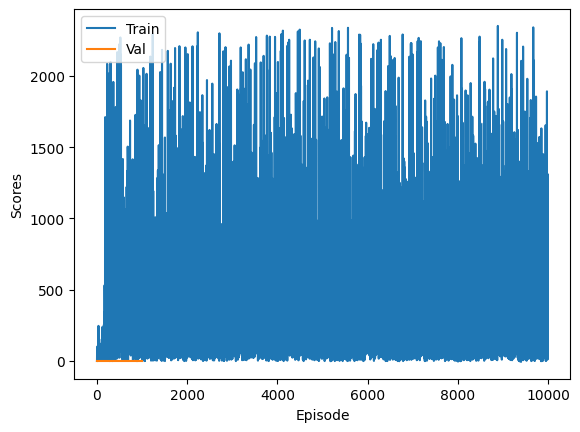

In [6]:
training_scores = np.array(training_scores)
validation_scores = np.array(validation_scores)
fig, axs = plt.subplots()
axs.plot(training_scores,'-',label='Train')
axs.set_ylabel('Scores')
axs.plot(validation_scores,'-',label='Val')
axs.set_xlabel('Episode')
axs.legend()
print(np.min(validation_scores))

In [ ]:
params = list(best_model.named_parameters())
print('The model has {:} different named parameters.\n'.format(len(params)))
for p in params:
    # print('p')
    # print(p[0])
    # print(p[1].data)
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(best_model)


In [ ]:
!gsutil cp -r ../staging_area/gait-model ../full_models/
!zip -r ../full_models/gait-model.zip ../full_models/gait-model/

In [ ]:
!gsutil cp -r ../full_models/gait-model/ gs://ml_gait_estimation/full_models/
!gsutil cp ../full_models/gait-model.zip gs://ml_gait_estimation/full_models/
